## Step 1: Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import optuna
from optuna.samplers import TPESampler
import tqdm as notebook_tqdm

## Step 2: Load the data

In [2]:
data = pd.read_csv("modified_data (1).csv")
print(data.head())

   CASE_NO_PATIENT'S  A1  A2  A3  A4  A5  A6  A7  A8  A9  ...  \
0                  1   0   0   0   0   0   0   1   1   0  ...   
1                  2   1   1   0   0   0   1   1   0   0  ...   
2                  3   1   0   0   0   0   0   1   1   0  ...   
3                  4   1   1   1   1   1   1   1   1   1  ...   
4                  5   1   1   0   1   1   1   1   1   1  ...   

   Global developmental delay/intellectual disability  \
0                                                Yes    
1                                                Yes    
2                                                 No    
3                                                Yes    
4                                                Yes    

   Social/Behavioural Issues  Childhood Autism Rating Scale  Anxiety_disorder  \
0                         No                              1               Yes   
1                        Yes                              2               Yes   
2                      

## Step 3: Data cleaning

In [3]:
# Check for missing values and handle them
print("Missing values per column:\n", data.isnull().sum())
# Fill missing values appropriately
for column in data.columns:
    if data[column].dtype in ['int64', 'float64']:
        data[column].fillna(data[column].median(), inplace=True)
    else:
        data[column].fillna(data[column].mode()[0], inplace=True)

Missing values per column:
 CASE_NO_PATIENT'S                                      0
A1                                                     0
A2                                                     0
A3                                                     0
A4                                                     0
A5                                                     0
A6                                                     0
A7                                                     0
A8                                                     0
A9                                                     0
A10_Autism_Spectrum_Quotient                           0
Social_Responsiveness_Scale                            9
Age_Years                                              0
Qchat_10_Score                                        39
Speech Delay/Language Disorder                         0
Learning disorder                                      0
Genetic_Disorders                                      0
Dep

C:\Users\User\AppData\Local\Temp\ipykernel_11184\433963788.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11184\433963788.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [4]:
# Standardize categorical "Yes/No" columns
yes_no_columns = [
    'Global developmental delay/intellectual disability',
    'Social/Behavioural Issues',
    'Anxiety_disorder',
    'Jaundice',
    'Family_mem_with_ASD',
    'ASD_traits'
]
data[yes_no_columns] = data[yes_no_columns].apply(lambda x: x.str.strip().str.capitalize())

# Encode "Yes/No" columns as 1 and 0
for col in yes_no_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

In [5]:
#Define Feature and Target Variables
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

# Ensure 'ASD_traits' exists in your data
if 'ASD_traits' in data.columns:
    X = data.drop(['Social_Responsiveness_Scale','Speech Delay/Language Disorder','Learning disorder','Genetic_Disorders','Depression','Global developmental delay/intellectual disability',
    'Social/Behavioural Issues','Childhood Autism Rating Scale',
    'Anxiety_disorder','ASD_traits'], axis=1)  # Features (drop the target column)
    y = data['ASD_traits']  # Target (your 'ASD_traits' column)
else:
    raise KeyError("The 'ASD_traits' column is not found in the dataset")

## Step 4: Preprocessing and Model Training

In [6]:
## Step 4: Preprocessing and Model Training
# Define categorical and numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Apply scaling to numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # Apply one-hot encoding to categorical columns
    ]
)

X_processed = preprocessor.fit_transform(X)

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


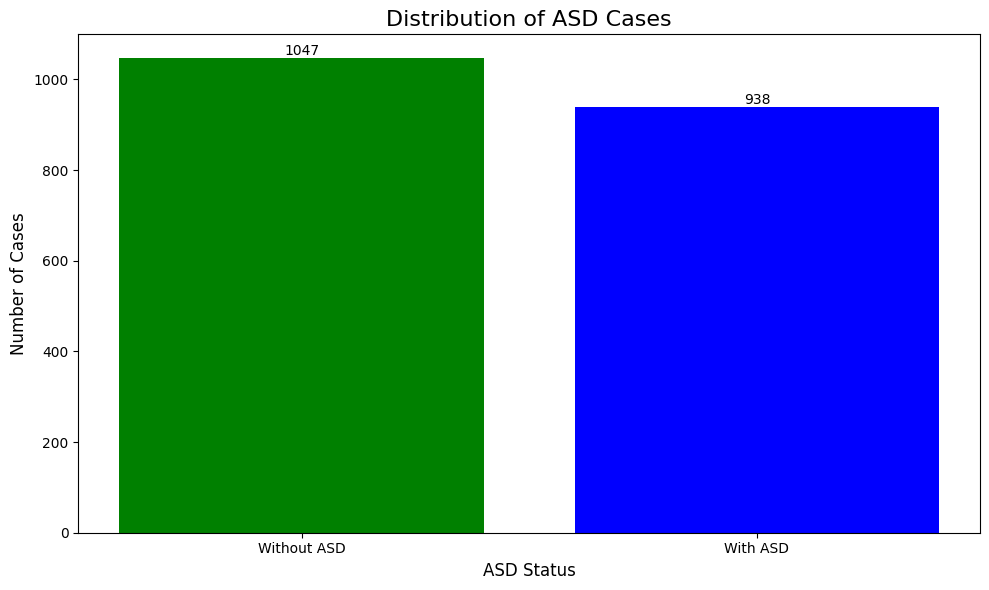

In [12]:
# Visualization of ASD Distribution
plt.figure(figsize=(10, 6))
asd_distribution = y.value_counts()
plt.bar(['Without ASD', 'With ASD'], asd_distribution.values, color=['green', 'blue'])
plt.title('Distribution of ASD Cases', fontsize=16)
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('ASD Status', fontsize=12)

# Add value labels on top of each bar
for i, v in enumerate(asd_distribution.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Step 5: Hyperparameter Optimization using Optuna for XGBoost

[I 2025-04-26 20:00:55,008] A new study created in memory with name: no-name-1f9bb7e8-2e69-4be9-9d13-e49de8745ce4
c:\Users\User\Downloads\Rahul\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-04-26 20:00:56,051] Trial 0 finished with value: 0.8085642317380353 and parameters: {'max_depth': 10, 'learning_rate': 0.07590280279366574, 'n_estimators': 88, 'subsample': 0.8168375813838699, 'colsample_bytree': 0.7476312563107603, 'gamma': 0.12171294187555781, 'reg_alpha': 0.4306324024048521, 'reg_lambda': 0.6387231213224592, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.8085642317380353.
c:\Users\User\Downloads\Rahul\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" }

XGBoost (Before Pruning) - Accuracy: 0.8287
XGBoost (Before Pruning) - Precision: 0.8104
XGBoost (Before Pruning) - Recall: 0.8593
XGBoost (Before Pruning) - ROC AUC: 0.8286


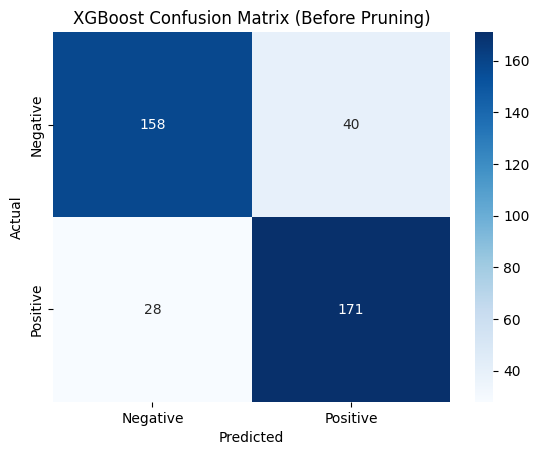

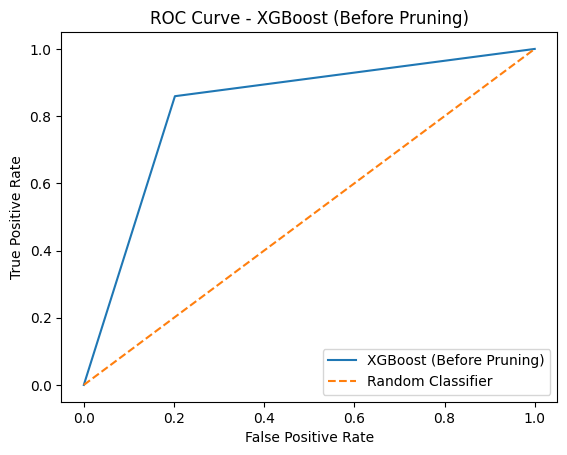

XGBoost (After Pruning) - Accuracy: 0.8589
XGBoost (After Pruning) - Precision: 0.8593
XGBoost (After Pruning) - Recall: 0.8593
XGBoost (After Pruning) - ROC AUC: 0.8589


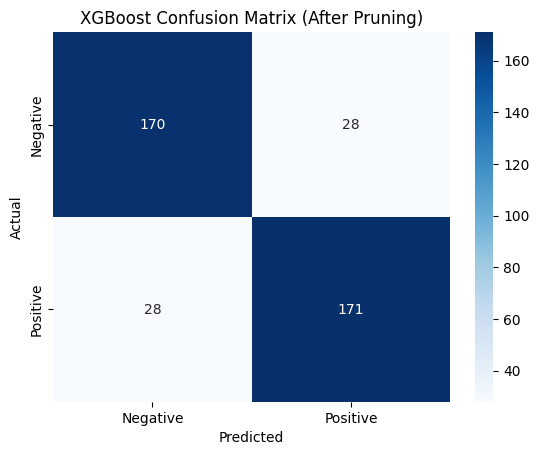

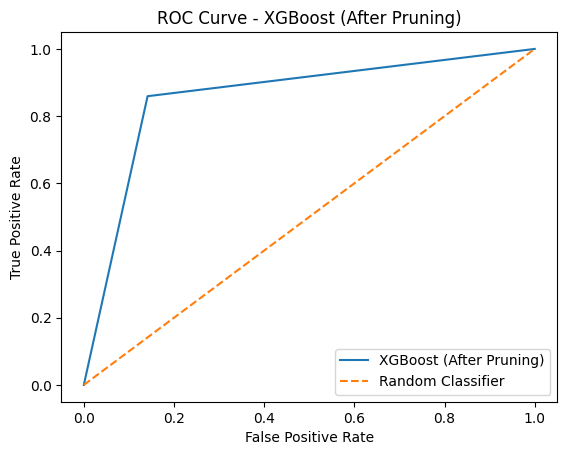

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.samplers import TPESampler

# Preprocessing function for categorical columns
def preprocess_data(X):
    categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        X[col] = label_encoder.fit_transform(X[col].astype(str))
    return X

# Define objective function for hyperparameter tuning (XGBoost)
def xgb_objective(trial):
    X_processed = preprocess_data(X)

    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 10),
        'enable_categorical': True
    }

    # Split data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Initialize Optuna study for XGBoost hyperparameter tuning
xgb_study = optuna.create_study(direction='maximize', sampler=TPESampler())
xgb_study.optimize(xgb_objective, n_trials=50)

# Best XGBoost Model after Hyperparameter Tuning
best_xgb_model = XGBClassifier(**xgb_study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the best XGBoost model on the full dataset
X_processed = preprocess_data(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predict on test set
xgb_preds = best_xgb_model.predict(X_test)

# XGBoost metrics before tuning
xgb_baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_baseline_model.fit(X_train, y_train)
xgb_baseline_preds = xgb_baseline_model.predict(X_test)

# Before Hyperparameter Tuning Metrics
accuracy_xgb_baseline = accuracy_score(y_test, xgb_baseline_preds)
precision_xgb_baseline = precision_score(y_test, xgb_baseline_preds, average='binary')
recall_xgb_baseline = recall_score(y_test, xgb_baseline_preds, average='binary')
roc_auc_xgb_baseline = roc_auc_score(y_test, xgb_baseline_preds)
conf_matrix_xgb_baseline = confusion_matrix(y_test, xgb_baseline_preds)

print(f"XGBoost (Before Pruning) - Accuracy: {accuracy_xgb_baseline:.4f}")
print(f"XGBoost (Before Pruning) - Precision: {precision_xgb_baseline:.4f}")
print(f"XGBoost (Before Pruning) - Recall: {recall_xgb_baseline:.4f}")
print(f"XGBoost (Before Pruning) - ROC AUC: {roc_auc_xgb_baseline:.4f}")

# Confusion Matrix (Before Pruning)
sns.heatmap(conf_matrix_xgb_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("XGBoost Confusion Matrix (Before Pruning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (Before Pruning)
fpr_xgb_baseline, tpr_xgb_baseline, _ = roc_curve(y_test, xgb_baseline_preds)
plt.plot(fpr_xgb_baseline, tpr_xgb_baseline, label='XGBoost (Before Pruning)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Before Pruning)')
plt.legend()
plt.show()

# After Hyperparameter Tuning - XGBoost
xgb_best_preds = best_xgb_model.predict(X_test)

# After Hyperparameter Tuning Metrics
accuracy_xgb_best = accuracy_score(y_test, xgb_best_preds)
precision_xgb_best = precision_score(y_test, xgb_best_preds, average='binary')
recall_xgb_best = recall_score(y_test, xgb_best_preds, average='binary')
roc_auc_xgb_best = roc_auc_score(y_test, xgb_best_preds)
conf_matrix_xgb_best = confusion_matrix(y_test, xgb_best_preds)

print(f"XGBoost (After Pruning) - Accuracy: {accuracy_xgb_best:.4f}")
print(f"XGBoost (After Pruning) - Precision: {precision_xgb_best:.4f}")
print(f"XGBoost (After Pruning) - Recall: {recall_xgb_best:.4f}")
print(f"XGBoost (After Pruning) - ROC AUC: {roc_auc_xgb_best:.4f}")

# Confusion Matrix (After Pruning)
sns.heatmap(conf_matrix_xgb_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("XGBoost Confusion Matrix (After Pruning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (After Pruning)
fpr_xgb_best, tpr_xgb_best, _ = roc_curve(y_test, xgb_best_preds)
plt.plot(fpr_xgb_best, tpr_xgb_best, label='XGBoost (After Pruning)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (After Pruning)')
plt.legend()
plt.show()


## Step 6: Hyperparameter Optimization using Optuna for Random Forest

[I 2025-04-26 20:02:01,623] A new study created in memory with name: no-name-e12b09f2-37e5-4458-9785-079f4c12994d


[I 2025-04-26 20:02:02,094] Trial 0 finished with value: 0.8639798488664987 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.8639798488664987.
[I 2025-04-26 20:02:02,695] Trial 1 finished with value: 0.8513853904282116 and parameters: {'n_estimators': 73, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 0 with value: 0.8639798488664987.
[I 2025-04-26 20:02:02,904] Trial 2 finished with value: 0.8614609571788413 and parameters: {'n_estimators': 51, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8639798488664987.
[I 2025-04-26 20:02:03,662] Trial 3 finished with value: 0.8564231738035264 and parameters: {'n_estimators': 111, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.8639798488664987.
[I 20

Random Forest (Before Pruning) - Accuracy: 0.8338
Random Forest (Before Pruning) - Precision: 0.8213
Random Forest (Before Pruning) - Recall: 0.8543
Random Forest (Before Pruning) - ROC AUC: 0.8337


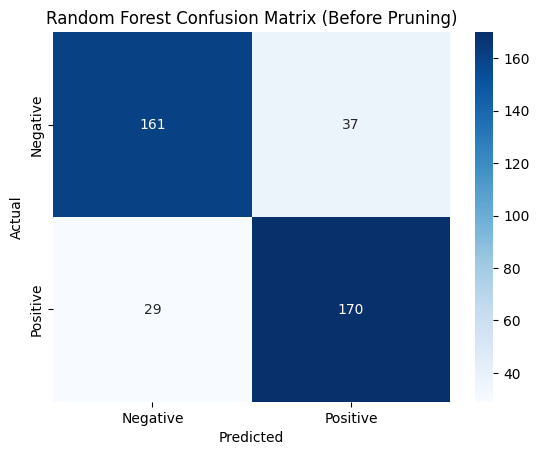

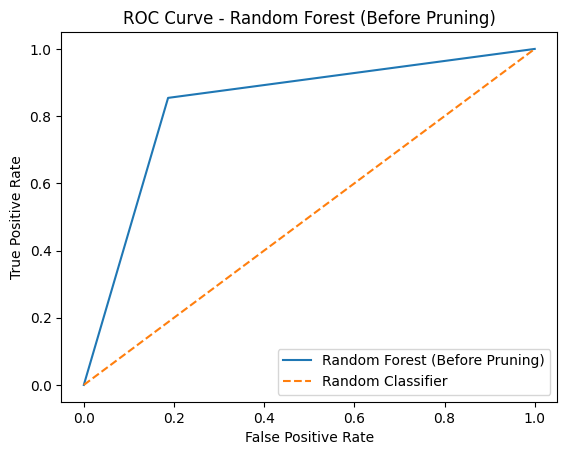

Random Forest (After Pruning) - Accuracy: 0.8640
Random Forest (After Pruning) - Precision: 0.8607
Random Forest (After Pruning) - Recall: 0.8693
Random Forest (After Pruning) - ROC AUC: 0.8640


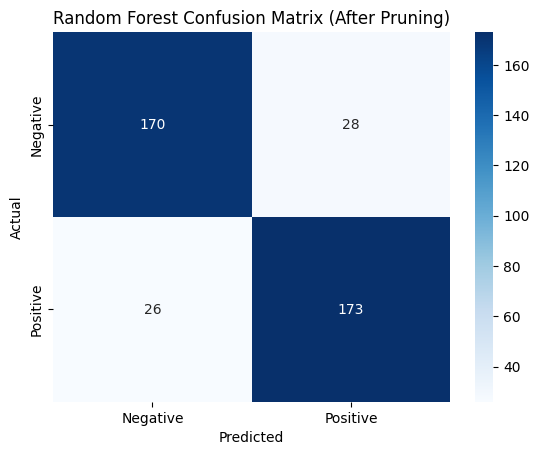

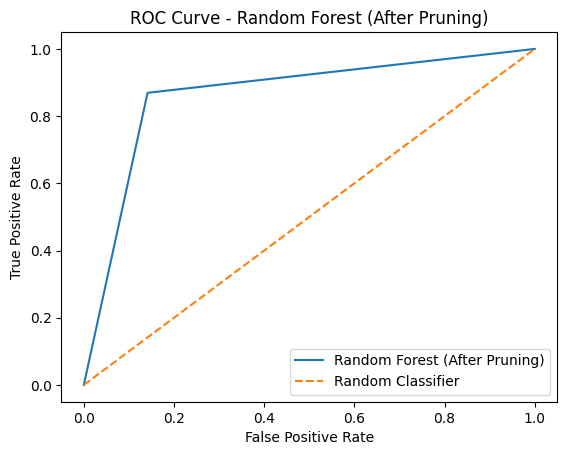

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split

# Define objective function for Random Forest hyperparameter tuning
def rf_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Split data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    rf_model = RandomForestClassifier(**param)
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Initialize Optuna study for Random Forest hyperparameter tuning
rf_study = optuna.create_study(direction='maximize', sampler=TPESampler())
rf_study.optimize(rf_objective, n_trials=50)

# Best Random Forest Model after Hyperparameter Tuning
best_rf_model = RandomForestClassifier(**rf_study.best_params, random_state=42)

# Train the best Random Forest model on the full dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict on test set
rf_preds = best_rf_model.predict(X_test)

# Random Forest metrics before tuning
rf_baseline_model = RandomForestClassifier(random_state=42)
rf_baseline_model.fit(X_train, y_train)
rf_baseline_preds = rf_baseline_model.predict(X_test)

# Before Hyperparameter Tuning Metrics
accuracy_rf_baseline = accuracy_score(y_test, rf_baseline_preds)
precision_rf_baseline = precision_score(y_test, rf_baseline_preds, average='binary')
recall_rf_baseline = recall_score(y_test, rf_baseline_preds, average='binary')
roc_auc_rf_baseline = roc_auc_score(y_test, rf_baseline_preds)
conf_matrix_rf_baseline = confusion_matrix(y_test, rf_baseline_preds)

print(f"Random Forest (Before Pruning) - Accuracy: {accuracy_rf_baseline:.4f}")
print(f"Random Forest (Before Pruning) - Precision: {precision_rf_baseline:.4f}")
print(f"Random Forest (Before Pruning) - Recall: {recall_rf_baseline:.4f}")
print(f"Random Forest (Before Pruning) - ROC AUC: {roc_auc_rf_baseline:.4f}")

# Confusion Matrix (Before Pruning)
sns.heatmap(conf_matrix_rf_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Random Forest Confusion Matrix (Before Pruning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (Before Pruning)
fpr_rf_baseline, tpr_rf_baseline, _ = roc_curve(y_test, rf_baseline_preds)
plt.plot(fpr_rf_baseline, tpr_rf_baseline, label='Random Forest (Before Pruning)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Before Pruning)')
plt.legend()
plt.show()

# After Hyperparameter Tuning - Random Forest
rf_best_preds = best_rf_model.predict(X_test)

# After Hyperparameter Tuning Metrics
accuracy_rf_best = accuracy_score(y_test, rf_best_preds)
precision_rf_best = precision_score(y_test, rf_best_preds, average='binary')
recall_rf_best = recall_score(y_test, rf_best_preds, average='binary')
roc_auc_rf_best = roc_auc_score(y_test, rf_best_preds)
conf_matrix_rf_best = confusion_matrix(y_test, rf_best_preds)

print(f"Random Forest (After Pruning) - Accuracy: {accuracy_rf_best:.4f}")
print(f"Random Forest (After Pruning) - Precision: {precision_rf_best:.4f}")
print(f"Random Forest (After Pruning) - Recall: {recall_rf_best:.4f}")
print(f"Random Forest (After Pruning) - ROC AUC: {roc_auc_rf_best:.4f}")

# Confusion Matrix (After Pruning)
sns.heatmap(conf_matrix_rf_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Random Forest Confusion Matrix (After Pruning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (After Pruning)
fpr_rf_best, tpr_rf_best, _ = roc_curve(y_test, rf_best_preds)
plt.plot(fpr_rf_best, tpr_rf_best, label='Random Forest (After Pruning)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (After Pruning)')
plt.legend()
plt.show()


## Step 7: Model Selection and Saving the Best Model

In [20]:
# Initialize an empty array to store metrics for both models after pruning
model_metrics = []

# XGBoost after pruning metrics
xgb_after_pruning = [
    accuracy_xgb_best,   # Accuracy for XGBoost after pruning
    precision_xgb_best,  # Precision for XGBoost after pruning
    recall_xgb_best,     # Recall for XGBoost after pruning
    roc_auc_xgb_best     # ROC AUC for XGBoost after pruning
]

# Random Forest after pruning metrics
rf_after_pruning = [
    accuracy_rf_best,    # Accuracy for Random Forest after pruning
    precision_rf_best,   # Precision for Random Forest after pruning
    recall_rf_best,      # Recall for Random Forest after pruning
    roc_auc_rf_best      # ROC AUC for Random Forest after pruning
]

# Append both model metrics to the array
model_metrics.append({
    'XGBoost': xgb_after_pruning,
    'Random Forest': rf_after_pruning
})

# Display the metrics array
print("Model Metrics (After Pruning):")
print(f"XGBoost Metrics: Accuracy: {xgb_after_pruning[0]:.4f}, Precision: {xgb_after_pruning[1]:.4f}, Recall: {xgb_after_pruning[2]:.4f}, ROC AUC: {xgb_after_pruning[3]:.4f}")
print(f"Random Forest Metrics: Accuracy: {rf_after_pruning[0]:.4f}, Precision: {rf_after_pruning[1]:.4f}, Recall: {rf_after_pruning[2]:.4f}, ROC AUC: {rf_after_pruning[3]:.4f}")

# Predict on the test set for both models
rf_test_preds = best_rf_model.predict(X_test)
xgb_test_preds = best_xgb_model.predict(X_test)

# Calculate accuracy for both models
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)

# Compare accuracies and save the best model
if rf_test_accuracy > xgb_test_accuracy:
    print(f"Random Forest has higher accuracy ({rf_test_accuracy:.4f}) than XGBoost ({xgb_test_accuracy:.4f}). Saving Random Forest model.")
    with open('model/best_model.pkl', 'wb') as file:
        pickle.dump(best_rf_model, file)
else:
    print(f"XGBoost has higher accuracy ({xgb_test_accuracy:.4f}) than Random Forest ({rf_test_accuracy:.4f}). Saving XGBoost model.")
    with open('model/best_model.pkl', 'wb') as file:
        pickle.dump(best_xgb_model, file)


Model Metrics (After Pruning):
XGBoost Metrics: Accuracy: 0.8589, Precision: 0.8593, Recall: 0.8593, ROC AUC: 0.8589
Random Forest Metrics: Accuracy: 0.8640, Precision: 0.8607, Recall: 0.8693, ROC AUC: 0.8640
Random Forest has higher accuracy (0.8640) than XGBoost (0.8589). Saving Random Forest model.
